# Estimating sediment mass displacement  on a small scale using digital elevation model differencing
## A Proof-Of-Concept Example

### Objective
Create a Python script that automates estimating sediment mass displacement on a small scale.

### Datasets
The two datasets used in this proof-of-concept exercise come from unmanned aerial vehicle (UAV) surveys carried out in Spring 2018 for CEWA 599: Advanced Surveying at the University of Washington (UW). Both datasets were collected on gravel paths near UW. For each dataset, two flights were carried out: (1) undisturbed and (2) disturbed. The undisturbed flight was over a 1-meter by 2-meter patch of gravel that was in its natural state. The disturbed flight was over that same 1-meter by 2-meter patch of gravel, only instead of being in its natural state, three 40-centimeter by 10-centimeter troughs were dug. At one of the sites (CUH), the troughs were approximately 0.5, 1.0, and 1.5 centimeters deep, and at the other site (RW), the troughs were approximately 3, 4, and 5 centimeters deep. 

The image and schematic below show the field setup:  

<img src="./images/field_setup.png">  
<img src="./images/site_setup.png">  

### Basic workflow
To estimate sediment mass displacement, the following workflow was used:
1. Pre-process digital elevation models (DEMs) to ensure same extent, resolution, projection
2. Difference the DEMs
3. Set noise threshold/outlier threshold
4. Mask differenced DEM so only valid data are shown
5. Convert from elevation difference to volume difference
6. Convert from volume to mass using approximate sediment density
___
First, we'll do some basic setup.

In [1]:
# Import packages
import numpy as np
import rasterio as rio
from rasterio import plot, mask
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set parameter for animation
plt.rcParams["animation.html"] = "html5"

# Import pretty print
from pprint import pprint

In [2]:
# Show plots in the notebook
%matplotlib inline

In [3]:
# Define datasets
CUH_before = './CUH_data/CUH_Before.tif'
CUH_after = './CUH_data/CUH_After.tif'

RW_before = './RW_data/RW_Before.tif'
RW_after = './RW_data/RW_After.tif'

We can open the datasets using the [rasterio](https://rasterio.readthedocs.io/en/stable/) package:

In [4]:
CUH_1 = rio.open(CUH_before)
CUH_2 = rio.open(CUH_after)

RW_1 = rio.open(RW_before)
RW_2 = rio.open(RW_after)

Let's look at the profiles for these datasets.

In [5]:
pprint(CUH_1.profile)
pprint(CUH_2.profile)

{'compress': 'lzw',
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2913,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.00177, 0.0, 553041.6500100001,
       0.0, -0.00177, 5278398.170650001),
 'width': 3013}
{'blockxsize': 256,
 'blockysize': 256,
 'compress': 'lzw',
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2933,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': True,
 'transform': Affine(0.00147, 0.0, 553042.0365749999,
       0.0, -0.00147, 5278397.901105),
 'width': 2556}


In [6]:
pprint(RW_1.profile)
pprint(RW_2.profile)

{'blockxsize': 128,
 'blockysize': 128,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2061,
 'interleave': 'band',
 'nodata': -3.402823e+38,
 'tiled': True,
 'transform': Affine(0.0016699999999971703, 0.0, 552405.6647736095,
       0.0, -0.0016700000001035344, 5277398.073834725),
 'width': 2001}
{'blockxsize': 256,
 'blockysize': 256,
 'compress': 'lzw',
 'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 2669,
 'interleave': 'band',
 'nodata': -3.4028230607370965e+38,
 'tiled': True,
 'transform': Affine(0.001289999999822, 0.0, 552405.6633287765,
       0.0, -0.001289999999822, 5277398.0753168),
 'width': 2591}


We can see that while the projections are the same, the resolutions and extents are not. To be able to difference the DEMs, we will need to ensure that they are the same projection, resolution, and extent.

We'll load the DEMs as arrays and plot them so we can see this graphically.

In [7]:
# Read in the DEMs
CUH_1_np = CUH_1.read(1)
CUH_2_np = CUH_2.read(1)

RW_1_np = RW_1.read(1)
RW_2_np = RW_2.read(1)

# Mask nodata values
CUH_1_mask = np.ma.masked_values(CUH_1_np, -10000.0)
CUH_2_mask = np.ma.masked_values(CUH_2_np, -10000.0)

RW_1_mask = np.ma.masked_values(RW_1_np, -3.402823e+38)
RW_2_mask = np.ma.masked_values(RW_2_np, -3.4028230607370965e+38)

In [8]:
# Define the figure and plot as animation for clarity - CUH
fig, ax = plt.subplots()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

im1 = plt.imshow(CUH_1_mask)
im2 = plt.imshow(CUH_2_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('CUH', fontweight='bold')

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

In [9]:
# Define the figure and plot as animation for clarity - RW
fig, ax = plt.subplots()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

im1 = plt.imshow(RW_1_mask)
im2 = plt.imshow(RW_2_mask)
ims = [[im1], [im2]]

plt.xlabel('Px', fontweight='bold')
plt.ylabel('Px', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('RW', fontweight='bold')

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

C:\Users\Amanda\Anaconda3\envs\gda_py3\lib\site-packages\matplotlib\image.py:419: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / 0.8)


We can see that the datasets cannot be differenced as they are currently.

To ensure the same projection, resolution, and extent, we can use the [`gdalwarp`](https://www.gdal.org/gdalwarp.html) command line utility. Below you'll see that instead of defining a normal rectangular extent using (right, bottom, left, top), I'm clipping the datasets to pre-defined shapefiles.

*_**Note:**_ I'm using the single `gdalwarp` command line utility here because I have only four rasters. If I had, say, 100 rasters, I would be much better off creating a shell script or using a `gdal` Python API.*

In [10]:
!gdalwarp -s_srs EPSG:32610 -t_srs EPSG:32610 \
        -of GTiff -cutline ./CUH_data/CUH_crop.shp -crop_to_cutline \
        -tr 0.00177 0.00177 -r cubic -overwrite \
        ./CUH_data/CUH_Before.tif ./CUH_data/CUH_before_proj.tif

Creating output file that is 1227P x 1384L.
Processing ./CUH_data/CUH_Before.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./CUH_data/CUH_Before.tif.
Copying nodata values from source ./CUH_data/CUH_Before.tif to destination ./CUH_data/CUH_before_proj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [11]:
!gdalwarp -s_srs EPSG:32610 -t_srs EPSG:32610 \
        -of GTiff -cutline ./CUH_data/CUH_crop.shp -crop_to_cutline \
        -tr 0.00177 0.00177 -r cubic -overwrite \
        ./CUH_data/CUH_After.tif ./CUH_data/CUH_after_proj.tif

Creating output file that is 1227P x 1384L.
Processing ./CUH_data/CUH_After.tif [1/1] : 0Using internal nodata values (e.g. -10000) for image ./CUH_data/CUH_After.tif.
Copying nodata values from source ./CUH_data/CUH_After.tif to destination ./CUH_data/CUH_after_proj.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [12]:
!gdalwarp -s_srs EPSG:32610 -t_srs EPSG:32610 \
        -of GTiff -cutline ./RW_data/RW_crop.shp -crop_to_cutline \
        -dstnodata -10000 \
        -tr 0.00167 0.00167  -r cubic -overwrite \
        ./RW_data/RW_Before.tif ./RW_data/RW_before_proj.tif

Creating output file that is 1876P x 1954L.
Processing ./RW_data/RW_Before.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ./RW_data/RW_Before.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [13]:
!gdalwarp -s_srs EPSG:32610 -t_srs EPSG:32610 \
        -of GTiff -cutline ./RW_data/RW_crop.shp -crop_to_cutline \
        -dstnodata -10000 \
        -tr 0.00167 0.00167 -r cubic -overwrite \
        ./RW_data/RW_After.tif ./RW_data/RW_after_proj.tif

Creating output file that is 1876P x 1954L.
Processing ./RW_data/RW_After.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image ./RW_data/RW_After.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


Now that we have DEMs that are the same projection, extent, and resolution, let's look at them.

In [14]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - CUH
CUH_1_proj = rio.open('./CUH_data/CUH_before_proj.tif')
pprint(CUH_1_proj.profile)
CUH_1_proj_read = CUH_1_proj.read(1)
CUH_1_proj_mask = np.ma.masked_values(CUH_1_proj_read, -10000.)
CUH_1_proj.close()

CUH_2_proj = rio.open('./CUH_data/CUH_after_proj.tif')
pprint(CUH_2_proj.profile)
CUH_2_proj_read = CUH_2_proj.read(1)
CUH_2_proj_mask = np.ma.masked_values(CUH_2_proj_read, -10000.)
CUH_2_proj.close()

{'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1384,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.00177, 0.0, 553043.2447800001,
       0.0, -0.00177, 5278397.44672),
 'width': 1227}
{'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1384,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.00177, 0.0, 553043.2449149999,
       0.0, -0.00177, 5278397.446874999),
 'width': 1227}


In [15]:
# Define plotting extent, then plot as animation for clarity - CUH
CUH_1_extent = rio.plot.plotting_extent(CUH_1_proj)
CUH_2_extent = rio.plot.plotting_extent(CUH_2_proj)

fig, ax = plt.subplots()
im1 = plt.imshow(CUH_1_proj_mask, extent=CUH_1_extent)
im2 = plt.imshow(CUH_2_proj_mask, extent=CUH_2_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('CUH', fontweight='bold')

ims = [[im1], [im2]]

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

In [16]:
# Read in each DEM for CUH, look at the profile, load the DEMs as arrays, and mask nodata values - RW
RW_1_proj = rio.open('./RW_data/RW_before_proj.tif')
pprint(RW_1_proj.profile)
RW_1_proj_read = RW_1_proj.read(1)
RW_1_proj_mask = np.ma.masked_values(RW_1_proj_read, -10000.)
RW_1_proj.close()

RW_2_proj = rio.open('./RW_data/RW_after_proj.tif')
pprint(RW_2_proj.profile)
RW_2_proj_read = RW_2_proj.read(1)
RW_2_proj_mask = np.ma.masked_values(RW_2_proj_read, -10000.)
RW_2_proj.close()

{'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1954,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.00167, 0.0, 552405.7633036094,
       0.0, -0.00167, 5277397.992004725),
 'width': 1876}
{'count': 1,
 'crs': CRS.from_dict(init='epsg:32610'),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 1954,
 'interleave': 'band',
 'nodata': -10000.0,
 'tiled': False,
 'transform': Affine(0.00167, 0.0, 552405.7626587765,
       0.0, -0.00167, 5277397.9914668),
 'width': 1876}


In [17]:
# Define plotting extent, then plot as animation for clarity - RW
RW_1_extent = rio.plot.plotting_extent(RW_1_proj)
RW_2_extent = rio.plot.plotting_extent(RW_2_proj)

fig, ax = plt.subplots()
im1 = plt.imshow(RW_1_proj_mask, extent=RW_1_extent)
im2 = plt.imshow(RW_2_proj_mask, extent=RW_2_extent)

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.colorbar(label='Elevation (m)')
plt.title('RW', fontweight='bold')

ims = [[im1], [im2]]

anim = animation.ArtistAnimation(fig, ims, interval=2000, repeat_delay=1000)
plt.close()

anim

Excellent! Our DEMs for each site now match. Let's difference them and plot the output:

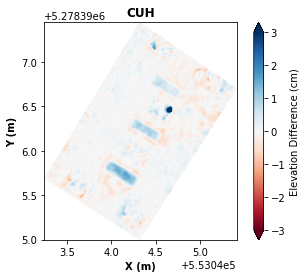

In [18]:
difference_CUH = (CUH_1_proj_mask-CUH_2_proj_mask)*100

fig, ax = plt.subplots()
plt.imshow(difference_CUH, cmap = 'RdBu', vmin=-3, vmax = 3, extent=CUH_1_extent)
plt.colorbar(label='Elevation Difference (cm)', extend='both')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('CUH', fontweight='bold')
plt.show()

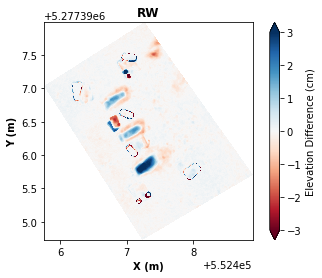

In [19]:
difference_RW = (RW_1_proj_mask-RW_2_proj_mask)*100

fig, ax = plt.subplots()
plt.imshow(difference_RW, cmap = 'RdBu', vmin=-3, vmax = 3, extent=RW_1_extent)
plt.colorbar(label='Elevation Difference (cm)', extend='both')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('RW', fontweight='bold')
plt.show()

Remember that we're trying to get the sediment mass that was displaced in the three human-dug troughs. Looking at the difference map, we see that we have a little bit of noise as well as an outlier or two. We can deal with both of these by assigning a noise threshold and an outlier threshold.  
Currently, the noise thresholds and outlier thresholds are being set as:

$ noise = |\sigma_{diff} + \bar{x}_{diff}|$  
$ outlier = |6*\sigma_{diff} + \bar{x}_{diff}|$  

where $\sigma_{diff}$ is the standard deviation of the differenced DEM values and $\bar{x}_{diff}$ is the mean of differenced DEM values.

*_**Note:**_ The thresholds for noise and for outliers were defined visually/using trial and error and are therefore not perfect. More sophisticated methods of determining these thresholds (e.g., spatial autocorrelation) will be used in future iterations of this code.*

After calculating the thresholds, we can mask the DEMs such that we have only the data that we'll use to calculate the sediment mass that was displaced and plot the data.

In [20]:
# Calculate std and mean - CUH
std_diff_CUH = difference_CUH.std()
mean_diff_CUH = difference_CUH.mean()

# Calculate thresholds
noise_threshold_CUH = np.abs(std_diff_CUH + mean_diff_CUH)
outlier_threshold_CUH = np.abs(6*std_diff_CUH + mean_diff_CUH)

# Create threshold mask
threshold_mask_CUH = np.ma.masked_outside(difference_CUH, noise_threshold_CUH, outlier_threshold_CUH)

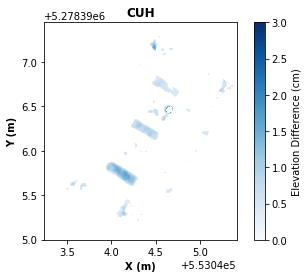

In [21]:
# Plot the masked array - CUH
fig, ax = plt.subplots()

plt.imshow(threshold_mask_CUH, cmap='Blues', vmin=0, vmax = 3, extent=CUH_1_extent)
plt.colorbar(label='Elevation Difference (cm)')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('CUH', fontweight='bold')
plt.show()

In [22]:
# Calculate std and mean - RW
std_diff_RW = difference_RW.std()
mean_diff_RW = difference_RW.mean()

# Calculate thresholds
noise_threshold_RW = np.abs(std_diff_RW + mean_diff_RW)
outlier_threshold_RW = np.abs(7*std_diff_RW + mean_diff_RW)

# Create threshold mask
threshold_mask_RW = np.ma.masked_outside(difference_RW, noise_threshold_RW, outlier_threshold_RW)

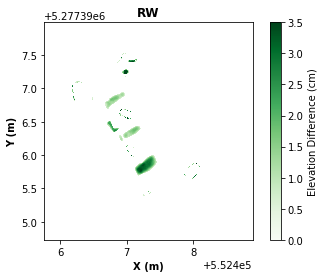

In [23]:
# Plot the masked array - RW
fig, ax = plt.subplots()

plt.imshow(threshold_mask_RW, cmap='Greens', vmin=0, vmax = 3.5, extent=RW_1_extent)
plt.colorbar(label='Elevation Difference (cm)')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('RW', fontweight='bold')
plt.show()

As seen above, we capture almost all of the three troughs, plus a little extra. Future iterations of the code will (hopefully) capture only the significant data, but for now, we can convert these data to volumes (in cm$^3$) and plot the output.

In [24]:
# Get cell width and cell height from the raster - CUH
cell_width_CUH, cell_height_CUH = CUH_1_proj.res

# Volume is a simple elevation difference*width*height calculation
volume_CUH = threshold_mask_CUH * cell_width_CUH * cell_height_CUH * 10000 #extra 10000 factor to get cm^3

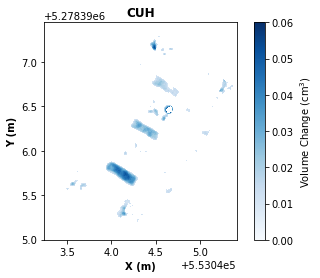

In [25]:
fig, ax = plt.subplots()

plt.imshow(volume_CUH, cmap='Blues', extent=CUH_1_extent, vmin=0, vmax = 0.06)
plt.colorbar(label='Volume Change (cm$^3$)')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('CUH', fontweight='bold')
plt.show()

In [26]:
# Get cell width and cell height from the raster - RW
cell_width_RW, cell_height_RW = RW_1_proj.res

# Volume is a simple elevation difference*width*height calculation
volume_RW = threshold_mask_RW * cell_width_RW * cell_height_RW * 10000 #extra 10000 factor to get cm^3

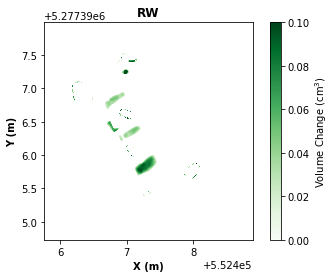

In [27]:
fig, ax = plt.subplots()

plt.imshow(volume_RW, cmap='Greens', extent=RW_1_extent, vmin=0, vmax=0.1)
plt.colorbar(label='Volume Change (cm$^3$)')

ax.set_xlabel('X (m)', fontweight='bold')
ax.set_ylabel('Y (m)', fontweight='bold')
plt.title('RW', fontweight='bold')
plt.show()

Now, we can convert the approximate volume of displaced sediment to the approximate mass of displaced sediment using $mass =  density * volume$. We'll use a (very) general approximate sediment density for gravel of $1.52 \frac{g}{cm^3}$. Then, we'll sum the mass values from each cell to get an estimate for the mass of sediment displaced.

*_**Note:**_ The density will be refined using sediment data from field experiments in future iterations of this code.*

In [28]:
mass_CUH = volume_CUH*1.52
sum_mass_CUH = np.sum(mass_CUH)

In [29]:
mass_RW = volume_RW*1.52
sum_mass_RW = np.sum(mass_RW)

In [30]:
print('The mass of sediment displaced at CUH was %0.2f kilograms.' % (sum_mass_CUH/1000))
print('The mass of sediment displaced at RW was %0.2f kilograms.' % (sum_mass_RW/1000))

The mass of sediment displaced at CUH was 1.86 kilograms.
The mass of sediment displaced at RW was 3.97 kilograms.


These values aren't particularly realistic, but this is to be expected because:
1.  The sediment density used in this case likely does not accurately represent the density of what was seen at these sites.
2. Not all outliers were fully removed, causing an overestimation.

Both of these issues will be addressed in future iterations of this notebook.